## Load, check, and record configuration

In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import yaml
import time
import pickle as pkl
import os
import numpy as np
from matplotlib import cm
from scipy.signal import welch,periodogram
import pandas as pd
import glob
from scipy.optimize import curve_fit
from scipy import signal

import pysmurf.client
import matplotlib.pylab as plt
import numpy as np
import sys
import os
epics_prefix="smurf_server_s3"
config_file=os.path.abspath("/usr/local/src/pysmurf/cfg_files/lab1/experiment_lab1_rfsoc.cfg")
S = pysmurf.client.SmurfControl(epics_root=epics_prefix,cfg_file=config_file,setup=False,make_logfile=False,shelf_manager="shm-smrf-sp01")

[ 2025-11-20 23:00:47 ]  ERROR : band 0 is present in pysmurf cfg file, but its bay is not enabled!
[ 2025-11-20 23:00:47 ]  ERROR : band 1 is present in pysmurf cfg file, but its bay is not enabled!
[ 2025-11-20 23:00:47 ]  ERROR : band 2 is present in pysmurf cfg file, but its bay is not enabled!
[ 2025-11-20 23:00:47 ]  ERROR : band 3 is present in pysmurf cfg file, but its bay is not enabled!
[ 2025-11-20 23:00:47 ]  ERROR : band 4 is present in pysmurf cfg file, but its bay is not enabled!
[ 2025-11-20 23:00:47 ]  ERROR : band 5 is present in pysmurf cfg file, but its bay is not enabled!
[ 2025-11-20 23:00:47 ]  ERROR : band 6 is present in pysmurf cfg file, but its bay is not enabled!
[ 2025-11-20 23:00:47 ]  ERROR : band 7 is present in pysmurf cfg file, but its bay is not enabled!


In [2]:
pysmurf.__version__

'8.0.0-rc3+12.gc1067044.dirty'

In [3]:
!git branch

* zcu208-devel


In [4]:
S._caget(f'{epics_prefix}:AMCc:RogueVersion', as_string=True)

'v4.11.11'

In [5]:
S._caget(f'{epics_prefix}:AMCc:SmurfApplication:SmurfVersion', as_string=True)

'8.0.0-rc3+12.gc1067044'

In [6]:
S._caget(f'{epics_prefix}:AMCc:SmurfApplication:StartupArguments', as_string=True)

'-w smurf_server_s3 -l 1 -d /tmp/fw/smurf_cfg/defaults/defaults_rfsoc_zcu208.yml -e smurf_server_s3 --disable-bay0 --disable-bay1 -a 10.0.1.103'

In [7]:
S.get_fpga_git_hash_short()

'ed145d0'

In [8]:
#S.check_jesd(0)

In [9]:
S.get_carrier_sn(use_shell=True)

[ 2025-11-20 23:00:50 ]  ERROR : Carrier FRU information incomplete or missing "Product Version" and/or "Product Asset Tag" fields.  Returning None.


In [10]:
S.get_rtm_sn(use_shell=True)

[ 2025-11-20 23:00:51 ]  ERROR : RTM FRU information incomplete or missing "Product Version" and/or "Product Asset Tag" fields.  Returning None.


In [11]:
S.get_amc_sn(0,use_shell=True)

[ 2025-11-20 23:00:51 ]  ERROR : AMC FRU information incomplete or missing "Product Version" and/or "Product Asset Tag" fields.  Returning None.


# Single channel

In [12]:
def welch_IQ(iq, fs,  plot=True, welch_nperseg=2**18, title='', show_plot=True):
    i = iq.real
    q = iq.imag
    ffi, pxxi = welch(i,fs=fs, nperseg=welch_nperseg)
    ffq, pxxq = welch(q,fs=fs, nperseg=welch_nperseg)

    # scale to dBc/Hz by the voltage magnitude
    magfac = np.mean(q)**2 + np.mean(i)**2
    pxxi_dbc = 10. * np.log10(pxxi / magfac)
    pxxq_dbc = 10. * np.log10(pxxq / magfac)


    if plot:
        plt.gca().semilogx(ffi,pxxi_dbc,linestyle='-',label=f'i {title}')
        plt.gca().semilogx(ffq,pxxq_dbc, linestyle='--',label=f'q {title}')
        plt.ylabel('dBc/Hz')
        plt.xlabel('Frequency (Hz)')
        plt.title(title)
        plt.legend(loc='lower left')
        if show_plot: plt.show()
    return 0

def takeDebugData(S, band, channel, nsamp, plot=True, welch_nperseg=2**18, show_plot=True, channel_mode=2):
    timestamp = S.get_timestamp() 
    filename = f'{timestamp}_multi_channel_b{band}'
    if channel is not None:
        filename = f'{timestamp}_single_channel_b{band}ch{channel:03}'
    i,q,sync = S.take_debug_data(band=band,channel=channel,rf_iq=True,nsamp=nsamp,filename=filename, single_channel_readout=channel_mode) 
    i = i / (1.2)
    q = q / (-1.2)
    iq = i + 1j * q
    if plot: 
        fs = S.get_channel_frequency_mhz(band) * 1.0E6
        if channel_mode==1:
            fs/=2.
            fs/=(S.get_decimation(band)+1.)
        welch_IQ(iq, fs, welch_nperseg, title=filename, show_plot=show_plot)
        ### save plots 
        fig = plt.gcf()
        #plt.savefig(f'/data/smurf_data/mkid_1tone_streaming_metadata/_Figs/{filename}_psd', fmt='tiff')
        plt.show()
    return iq, sync, filename

In [13]:
S.get_band_center_mhz(0)

750.0

In [14]:
S.which_bands()

[0, 1, 2, 3, 4, 5, 6, 7]

In [13]:
S.all_off()
try:
    band,channel=S.set_fixed_tone(S.get_band_center_mhz(0),12)
except:
    #turn off bands
    for band in S.which_bands():
        for chan in S.which_on(band):
            S.set_amplitude_scale_channel(band, chan, 0)
    band,channel=S.set_fixed_tone(S.get_band_center_mhz(0),12)

[ 2025-11-20 23:01:02 ]  Turning off tones
[ 2025-11-20 23:01:19 ]  Turning off flux ramp
[ 2025-11-20 23:01:19 ]  Turning off all TES biases


In [14]:
print("bands:", band)
print("channel:", channel)
print("which_bands:", S.which_bands())
print("which_on(band):", S.which_on(band))
print("diff:", np.diff(S.which_on(band)))
subband, foff = S.freq_to_subband(band, S.get_band_center_mhz(0))
print("subband:", subband)
subband_channels = S.get_channels_in_subband(band, subband)
print("subband_channels:", subband_channels)
print("get num processed channels:", S.get_number_processed_channels(band))
print("\n")

bands: 0
channel: 0
which_bands: [0, 1, 2, 3, 4, 5, 6, 7]
which_on(band): [0]
diff: []
subband: 255
subband_channels: [0]
get num processed channels: 416




[ 2025-11-18 00:49:01 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:readoutChannelSelect 0
[ 2025-11-18 00:49:01 ]  Writing to file : /data/smurf_data/20251118/1763426919/outputs/1763426941_single_channel_b0ch000.dat
[ 2025-11-18 00:49:01 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 33554432
[ 2025-11-18 00:49:01 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2025-11-18 00:49:01 ]  Data acquisition in progress...
[ 2025-11-18 00:49:01 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2025-11-18 00:49:18 ]  Done taking data


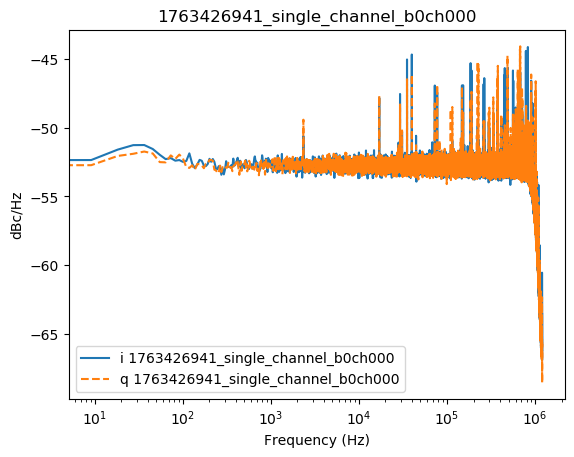

<Figure size 640x480 with 0 Axes>

CPU times: user 12.8 s, sys: 3.51 s, total: 16.3 s
Wall time: 33 s


In [17]:
%%time
iq,_,filename=takeDebugData(S,band=band,channel=channel,nsamp=2**25,plot=True,channel_mode=2)

From above, it took <16 sec to take the data (the other ~15sec was for plotting and data handling, probably). This is roughly consistent with 2**25 samples taken at 2.4 MHz ~ 14 sec acquisition.

Ok, now let's try mode 1. This

In mode 1, signle channel data should be returned at 1.2 MHz, and you can optionally filter and downsample the data. For reasons lost to time by default the downsampling is 2 (reg is set to 1, which corresponds to a decimation by (1+1) = 2);

To take data without any decimation, set to zero (for a sample decimation of 0+1=1;


In [18]:
S.set_decimation(band,0)
print(f'b0 decimation : {S.get_decimation(band)}')

b0 decimation : 0


In [ ]:
%%time
iq1,_,filename=takeDebugData(S,band=band,channel=channel,nsamp=2**25,plot=True,channel_mode=1)

[ 2025-11-18 00:52:11 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:readoutChannelSelect 0
[ 2025-11-18 00:52:11 ]  Writing to file : /data/smurf_data/20251118/1763426919/outputs/1763427132_single_channel_b0ch000.dat
[ 2025-11-18 00:52:11 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 33554432
[ 2025-11-18 00:52:11 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2025-11-18 00:52:11 ]  Data acquisition in progress...
[ 2025-11-18 00:52:11 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2025-11-18 00:52:28 ]  Done taking data


Here, acquisition took ~30sec as expected (2^25/(1.2e6) ~ 28 sec) and the noise agrees with the data taken in mode 0;

In [ ]:
from scipy import ndimage

ffq0, pxxq0 = welch(iq.imag,fs=2.4e6, nperseg=2**18)
ffq1, pxxq1 = welch(iq1.imag,fs=1.2e6, nperseg=2**18)
plt.semilogx(ffq0,ndimage.median_filter(10*np.log10(pxxq0),size=1))
plt.semilogx(ffq1,ndimage.median_filter(10*np.log10(pxxq1),size=1))

In [21]:
#S.set_debug_data_filter_cutoff(band, fcut_hz=10e3)

AttributeError: 'SmurfControl' object has no attribute 'set_debug_data_filter_cutoff'

Is filter being applied?

[ 2025-11-13 21:11:27 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:readoutChannelSelect 0
[ 2025-11-13 21:11:27 ]  Writing to file : /data/smurf_data/20251113/1763067645/outputs/1763068288_single_channel_b0ch000.dat
[ 2025-11-13 21:11:27 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 33554432
[ 2025-11-13 21:11:27 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2025-11-13 21:11:27 ]  Data acquisition in progress...
[ 2025-11-13 21:11:27 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2025-11-13 21:11:44 ]  Done taking data


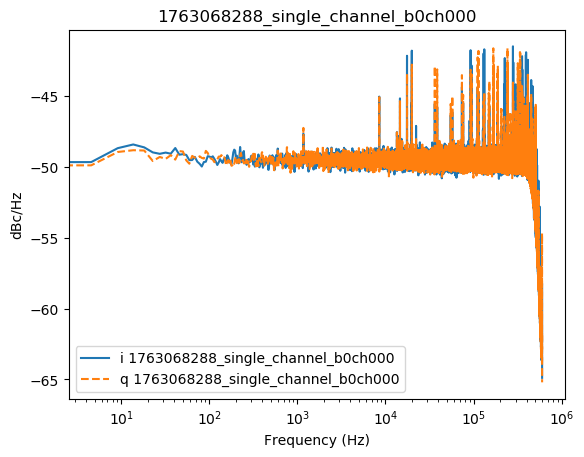

<Figure size 640x480 with 0 Axes>

CPU times: user 12.8 s, sys: 7.12 s, total: 19.9 s
Wall time: 36.4 s


In [22]:
%%time
iq1filt,_,filename=takeDebugData(S,band=band,channel=channel,nsamp=2**25,plot=True,channel_mode=1)

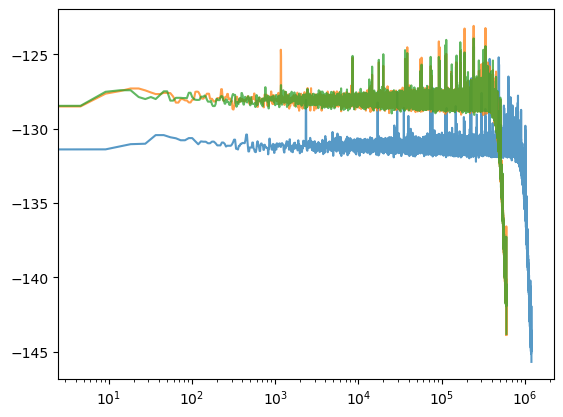

In [23]:
from scipy import ndimage

ffq1filt, pxxq1filt = welch(iq1filt.imag,fs=1.2e6, nperseg=2**18)
plt.semilogx(ffq0,ndimage.median_filter(10*np.log10(pxxq0),size=3),alpha=0.75)
plt.semilogx(ffq1,ndimage.median_filter(10*np.log10(pxxq1),size=3),alpha=0.75)
plt.semilogx(ffq1filt,ndimage.median_filter(10*np.log10(pxxq1filt),size=3),alpha=0.75)

Looks plausible.  Ok, so now should be able to decimate without incurring a noise penalty.  Let's try decimating to 30 kHz, or a factor of 40.  Must remember to adjust nsamp or your acq will take forever! 

In [24]:
S.set_decimation(band,39) # 39 is a decimation of 40, since the decimation is dec+1

[ 2025-11-13 21:12:11 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:readoutChannelSelect 0
[ 2025-11-13 21:12:11 ]  Writing to file : /data/smurf_data/20251113/1763067645/outputs/1763068332_single_channel_b0ch000.dat
[ 2025-11-13 21:12:11 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 838860
[ 2025-11-13 21:12:11 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2025-11-13 21:12:11 ]  Data acquisition in progress...
[ 2025-11-13 21:12:11 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2025-11-13 21:12:13 ]  Done taking data


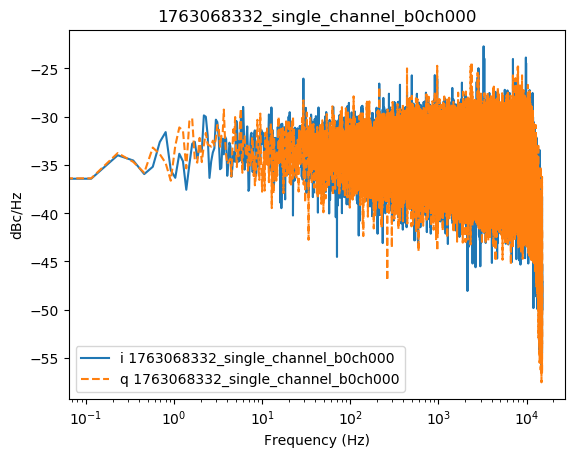

<Figure size 640x480 with 0 Axes>

CPU times: user 1.19 s, sys: 55.7 ms, total: 1.25 s
Wall time: 3.6 s


In [25]:
%%time
iq1filtdec,_,filename=takeDebugData(S,band=band,channel=channel,nsamp=int(2**25/(S.get_decimation(band)+1)),plot=True,channel_mode=1)

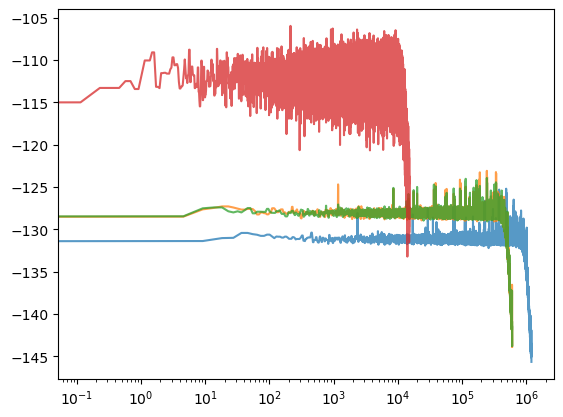

In [26]:
from scipy import ndimage

ffq1filtdec, pxxq1filtdec = welch(iq1filtdec.imag,fs=1.2e6/(S.get_decimation(band)+1), nperseg=2**18)
plt.semilogx(ffq0,ndimage.median_filter(10*np.log10(pxxq0),size=3),alpha=0.75)
plt.semilogx(ffq1,ndimage.median_filter(10*np.log10(pxxq1),size=3),alpha=0.75)
plt.semilogx(ffq1filt,ndimage.median_filter(10*np.log10(pxxq1filt),size=3),alpha=0.75)
plt.semilogx(ffq1filtdec,ndimage.median_filter(10*np.log10(pxxq1filtdec),size=3),alpha=0.75)

Ok, should be ready for multitone now.

# Multitone

For multitone, just don't pass a channel.  Remember your samples will get split across the 416 fw channels and increase accordingly.  Also be aware these files can get *big*

In [15]:
%%time
#iq1filtdecmultitone,_,filename=takeDebugData(S,band=band,channel=None,nsamp=int(S.get_number_processed_channels(band)*2**25/(S.get_decimation(band)+1)),plot=False)
iq1filtdecmultitone,_,filename=takeDebugData(S,band=band,channel=None,nsamp=2**25,plot=False)

[ 2025-11-20 23:01:55 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:singleChannelReadout 0
[ 2025-11-20 23:01:55 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:singleChannelReadoutOpt2 0
[ 2025-11-20 23:01:55 ]  Writing to file : /data/smurf_data/20251120/1763679648/outputs/1763679715_multi_channel_b0.dat
[ 2025-11-20 23:01:55 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 33554432
[ 2025-11-20 23:01:55 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2025-11-20 23:01:55 ]  Data acquisition in progress...
[ 2025-11-20 23:01:55 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2025-11-20 23:01:57 ]  Done taking data
CPU times: user 6.99 s, sys: 8.21 s, total: 15.2 s
Wall time: 18.1 s


In [16]:
iq1filtdecmultitone.shape

(33554432,)

In [18]:
S.set_fixed_tone(505,12)

(0, 89)

In [19]:
S.which_on(0)

array([ 0, 89])

In [ ]:
iq_z, _, _ =S.take_debug_data(band=0,channel=None,rf_iq=True,nsamp=2**26) 

print(np.shape(iq_z))

[ 2025-11-20 23:09:34 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:singleChannelReadout 0
[ 2025-11-20 23:09:34 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:singleChannelReadoutOpt2 0
[ 2025-11-20 23:09:34 ]  Writing to file : /data/smurf_data/20251120/1763679648/outputs/1763680175.dat
[ 2025-11-20 23:09:34 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 67108864
[ 2025-11-20 23:09:34 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2025-11-20 23:09:34 ]  Data acquisition in progress...
[ 2025-11-20 23:09:34 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2025-11-20 23:09:38 ]  Done taking data


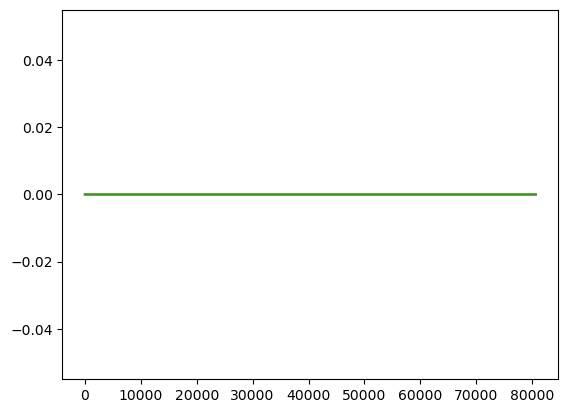

In [21]:
plt.plot(iq_z[::416])
plt.plot(iq_z[89::416])
plt.plot(iq_z[90::416])

/usr/local/lib/python3.8/dist-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 262144 is greater than input length  = 80660, using nperseg = 80660
  warnings.warn('nperseg = {0:d} is greater than input length '


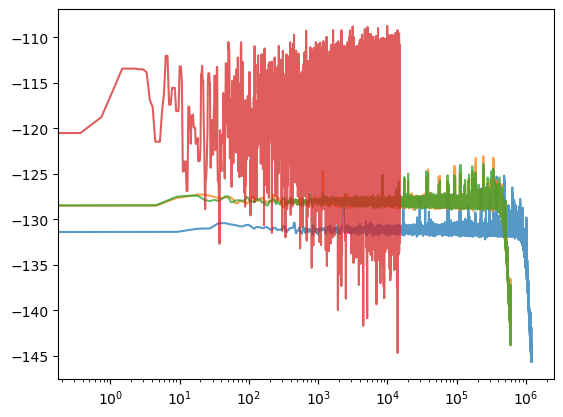

In [28]:
ffq1filtdecmultitone, pxxq1filtdecmultitone = welch(iq1filtdecmultitone.imag[0::416],fs=1.2e6/(S.get_decimation(band)+1), nperseg=2**18)
plt.semilogx(ffq0,ndimage.median_filter(10*np.log10(pxxq0),size=3),alpha=0.75)
plt.semilogx(ffq1,ndimage.median_filter(10*np.log10(pxxq1),size=3),alpha=0.75)
plt.semilogx(ffq1filt,ndimage.median_filter(10*np.log10(pxxq1filt),size=3),alpha=0.75)
plt.semilogx(ffq1filtdecmultitone,ndimage.median_filter(10*np.log10(pxxq1filtdecmultitone),size=3),alpha=0.75)

Good.  Now let's do a true multitone measurement.

In [29]:
S.band_off(band)
chans=[]
for foff in [-225,-135,-17,0,94,196]:
    (_,chan)=S.set_fixed_tone(S.get_band_center_mhz(band)+foff,12)

Which channels are on?

In [30]:
S.which_on(band)

array([  0,  69, 159, 228, 394, 483])

Take multitone data...

In [31]:
%%time
#iq1filtdecmultitone,_,filename=takeDebugData(S,band=band,channel=None,nsamp=int(S.get_number_processed_channels(band)*2**25/(S.get_decimation(band)+1)),plot=False)
iq1filtdecmultitone2,_,filename=takeDebugData(S,band=band,channel=None,nsamp=2**24,plot=False)

[ 2025-11-13 21:14:23 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:singleChannelReadout 0
[ 2025-11-13 21:14:23 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:singleChannelReadoutOpt2 0
[ 2025-11-13 21:14:23 ]  Writing to file : /data/smurf_data/20251113/1763067645/outputs/1763068464_multi_channel_b0.dat
[ 2025-11-13 21:14:23 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 16777216
[ 2025-11-13 21:14:23 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2025-11-13 21:14:23 ]  Data acquisition in progress...
[ 2025-11-13 21:14:23 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:TriggerDaq 1
[ 2025-11-13 21:14:27 ]  Done taking data
CPU times: user 3.45 s, sys: 464 ms, total: 3.92 s
Wall time: 7.26 s


Hm, the array indices don't seem to line up with what I expect.  Compare;

In [32]:
S.which_on(band)

array([  0,  69, 159, 228, 394, 483])

In [33]:
np.nonzero(iq1filtdecmultitone2[:416])

(array([  0,  56, 129, 185, 320, 392]),)

We may have found a SMuRF bug!

/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


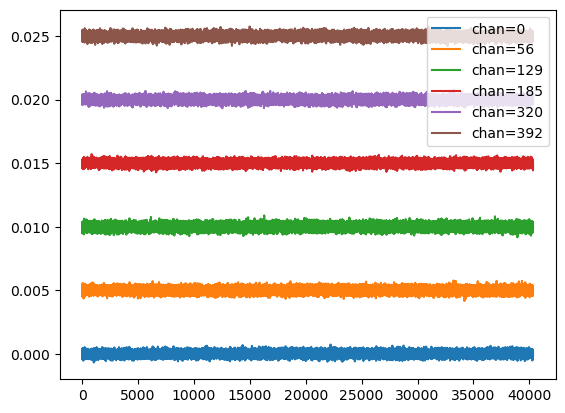

In [34]:
y_plotting_offset=0.005
for idx,chan in enumerate(np.nonzero(iq1filtdecmultitone2[:416])[0]):
    data=iq1filtdecmultitone2[chan::S.get_number_processed_channels(band)]
    plt.plot(data.imag-np.mean(data.imag)+y_plotting_offset*idx,label=f'chan={chan}')
#plt.plot(iq1filtdecmultitone2[56::416])
#plt.plot(iq1filtdecmultitone2[129::416])
plt.legend()